In [1]:
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import matplotlib as mpl
from sentence_transformers import SentenceTransformer, util


# Mac 환경 한글 폰트 설정
plt.rc('font', family='AppleGothic')
mpl.rcParams['axes.unicode_minus'] = False

# Set path
os.chdir("/Users/yshmbid/Documents/home/github/Data-MLOps/0814")
os.getcwd()

/opt/anaconda3/envs/skala/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'/Users/yshmbid/Documents/home/github/Data-MLOps/0814'

In [2]:
# 1. 데이터 불러오기
df = pd.read_csv('reviews.csv')
df

,review_id,product_id,category,review_text,review_length,num_words,sentiment_score,rating
0,R0001,P158,home,Amazing quality and fast shipping.,134,27,-0.60,3
1,R0002,P117,fashion,"Just okay, nothing special.",115,28,-0.10,5
2,R0003,P160,fashion,Not worth the money.,139,32,0.20,5
3,R0004,P127,fashion,"Just okay, nothing special.",165,32,0.22,4
4,R0005,P151,home,"Just okay, nothing special.",112,15,-0.03,4
...,...,...,...,...,...,...,...,...
195,R0196,P193,electronics,Amazing quality and fast shipping.,131,21,-0.06,5
196,R0197,P153,sports,Not worth the money.,93,13,0.07,5
197,R0198,P169,sports,"Excellent product, I loved it!",124,34,-0.29,3
198,R0199,P156,sports,"Just okay, nothing special.",121,24,-0.02,1


In [3]:
# 2. 결측치 및 기본 정보 확인
print("결측치 개수:\n", df.isnull().sum())
print("\n데이터 기본 정보:")
print(df.info())

# 결측치 처리: review_text 또는 sentiment_score 중 하나라도 결측인 행 제거
before_rows = df.shape[0]
df = df.dropna(subset=['review_text', 'sentiment_score'], how='any')
after_rows = df.shape[0]

print(f"\n제거된 행 수: {before_rows - after_rows} ({(before_rows - after_rows) / before_rows * 100:.1f}% 데이터 손실)")
print(f"남은 데이터 수: {after_rows}개")

결측치 개수:
 review_id          0
product_id         0
category           0
review_text        5
review_length      0
num_words          0
sentiment_score    5
rating             0
dtype: int64

데이터 기본 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   review_id        200 non-null    object 
 1   product_id       200 non-null    object 
 2   category         200 non-null    object 
 3   review_text      195 non-null    object 
 4   review_length    200 non-null    int64  
 5   num_words        200 non-null    int64  
 6   sentiment_score  195 non-null    float64
 7   rating           200 non-null    int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 12.6+ KB
None

제거된 행 수: 10 (5.0% 데이터 손실)
남은 데이터 수: 190개


review_text와 sentiment_score 모두 결측인 행 제거. 리뷰 내용과 감성 점수가 없으면 분석에 활용 불가능
review_text만 결측이고 sentiment_score는 있는 경우
리뷰 길이(review_length)와 단어 수(num_words)가 있으니, 텍스트 분석은 제외하고 다른 수치 분석에는 사용 가능하지만
전체 200행 중 결측치가 단 5행이므로 제거 시 데이터 손실이 2.5%에 불과
결측값 대체(imputation)는 의미 있는 값을 만들기 어려움 (특히 텍스트와 감성 점수)

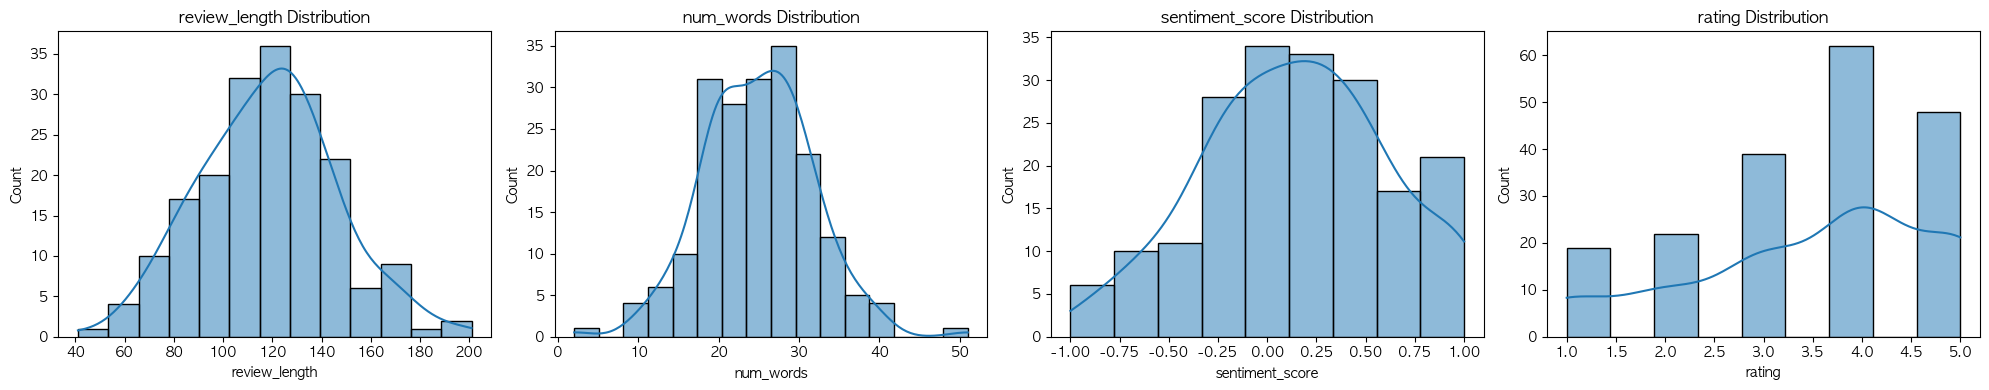

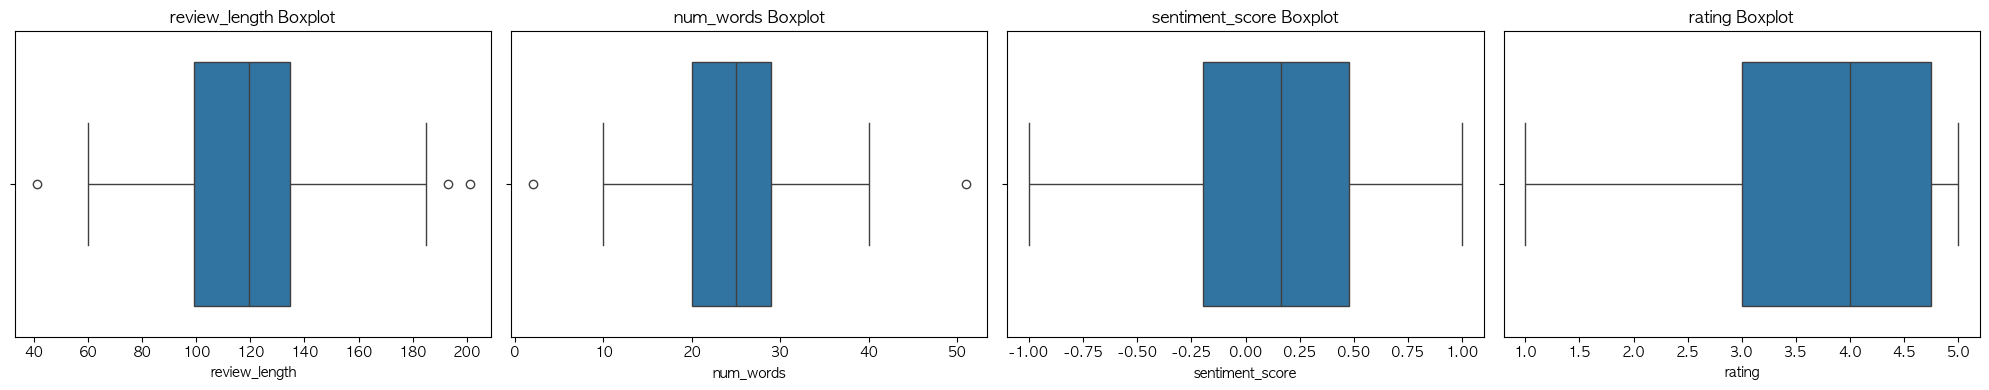

In [4]:

# 3. 분포 시각화 및 이상치 탐지
# 수치형 컬럼만 선택
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# 히스토그램 (분포 확인)
fig, axes = plt.subplots(nrows=1, ncols=len(numeric_cols), figsize=(5*len(numeric_cols), 4))
for ax, col in zip(axes, numeric_cols):
    sns.histplot(df[col], kde=True, ax=ax)
    ax.set_title(f'{col} Distribution')
plt.tight_layout()
plt.show()

# 박스플롯 (이상치 확인)
fig, axes = plt.subplots(nrows=1, ncols=len(numeric_cols), figsize=(5*len(numeric_cols), 4))
for ax, col in zip(axes, numeric_cols):
    sns.boxplot(x=df[col], ax=ax)
    ax.set_title(f'{col} Boxplot')
plt.tight_layout()
plt.show()

분포 시각화 결과를 보면 review_length와 num_words는 전형적인 종 모양의 분포를 보이지만 완벽한 정규분포는 아니며, review_length의 경우 약간 오른쪽 꼬리가 길고 num_words는 좌우 대칭성이 상대적으로 더 좋은 편이다. sentiment_score는 -1에서 1 사이의 범위로 고르게 분포하되 0 부근에 밀집된 경향이 있고, 양쪽 극단값도 적지 않게 분포하고 있다. rating은 1부터 5까지의 이산형 값으로 구성되어 있으며 4점과 5점이 우세하고 1점과 2점은 적은 비율을 차지해 치우친 분포를 보인다. 이상치 시각화에서는 review_length와 num_words 모두 박스플롯 기준에서 하단과 상단에 소수의 극단값이 존재하는데, 특히 review_length는 매우 짧거나 긴 리뷰가 확인되고 num_words 역시 단어 수가 극단적으로 적거나 많은 경우가 있다. sentiment_score에서는 -1과 1 근처의 극단값이 나타나지만 이는 감성 분석에서 강한 부정과 긍정을 나타내는 정상 범위로 볼 수 있어 보존하는 것이 타당하다. rating에서는 1점이 소수의 이상치처럼 보이지만 실제 저평가 사례로 해석 가능하므로 제거 대상은 아니다. 따라서 review_length와 num_words에 대해서만 IQR 기반으로 상하 경계 밖의 값을 제거하거나 상하위 1%를 잘라내는 방식이 적절하며, 나머지 sentiment_score와 rating의 극단값은 데이터의 의미를 유지하기 위해 그대로 두는 것이 좋다.

In [5]:
# 이상치 처리
df_clean = df.copy()

# review_length 상하위 1% 제거
lower_bound = df_clean['review_length'].quantile(0.01)
upper_bound = df_clean['review_length'].quantile(0.99)
df_clean = df_clean[(df_clean['review_length'] >= lower_bound) & (df_clean['review_length'] <= upper_bound)]

# num_words 상하위 1% 제거
lower_bound = df_clean['num_words'].quantile(0.01)
upper_bound = df_clean['num_words'].quantile(0.99)
df_clean = df_clean[(df_clean['num_words'] >= lower_bound) & (df_clean['num_words'] <= upper_bound)]

print("상하위 1% 절삭 후 데이터 크기:", df_clean.shape)


상하위 1% 절삭 후 데이터 크기: (184, 8)


category
electronics    3.764706
home           3.500000
fashion        3.469388
sports         3.285714
Name: rating, dtype: float64


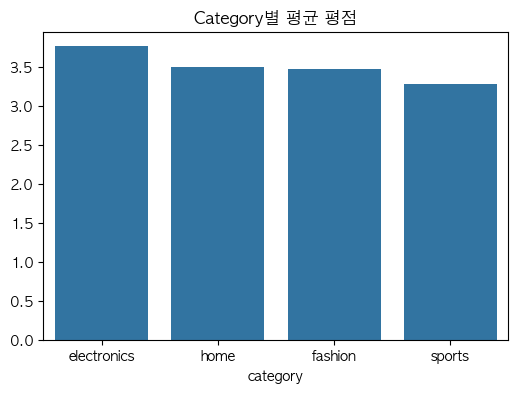

In [ ]:
# 4. 범주별 평균 평점
category_mean_rating = df.groupby('category')['rating'].mean().sort_values(ascending=False)
print(category_mean_rating)

# 시각화
plt.figure(figsize=(6,4))
sns.barplot(x=category_mean_rating.index, y=category_mean_rating.values)
plt.title("Category별 평균 평점")
plt.show()


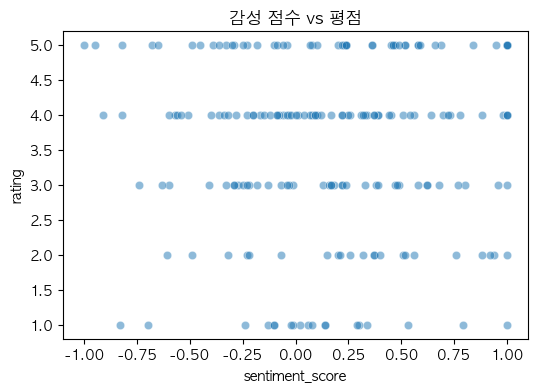

감성 점수와 평점의 상관계수: -0.020926485382556512


In [7]:
# 5. Sentiment Score vs Rating
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x='sentiment_score', y='rating', alpha=0.5)
plt.title("감성 점수 vs 평점")
plt.show()

# 상관계수 확인
corr_sentiment_rating = df['sentiment_score'].corr(df['rating'])
print("감성 점수와 평점의 상관계수:", corr_sentiment_rating)

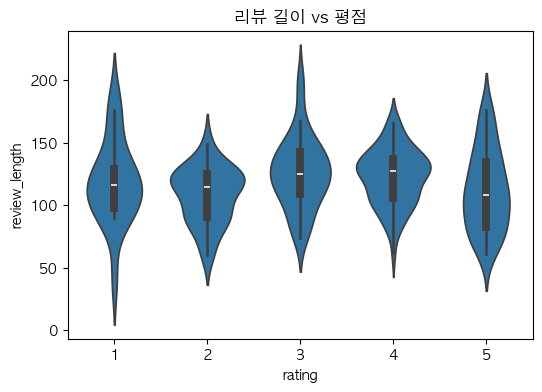

리뷰 길이와 평점의 상관계수: -0.018622392015914393


In [8]:
# 6. Review Length vs Rating (violinplot)
plt.figure(figsize=(6,4))
sns.violinplot(data=df, x='rating', y='review_length')
plt.title("리뷰 길이 vs 평점")
plt.show()

# 상관계수 확인
corr_length_rating = df['review_length'].corr(df['rating'])
print("리뷰 길이와 평점의 상관계수:", corr_length_rating)

Category별 평균 Sentiment Score:
category
sports         0.241842
fashion        0.152500
electronics    0.112400
home           0.069375
Name: sentiment_score, dtype: float64


/var/folders/5_/cr0lgx655m7fqg_j4q733qbm0000gn/T/ipykernel_17861/3166913194.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_clean, x='category', y='sentiment_score', ci=None, order=category_sentiment.index)


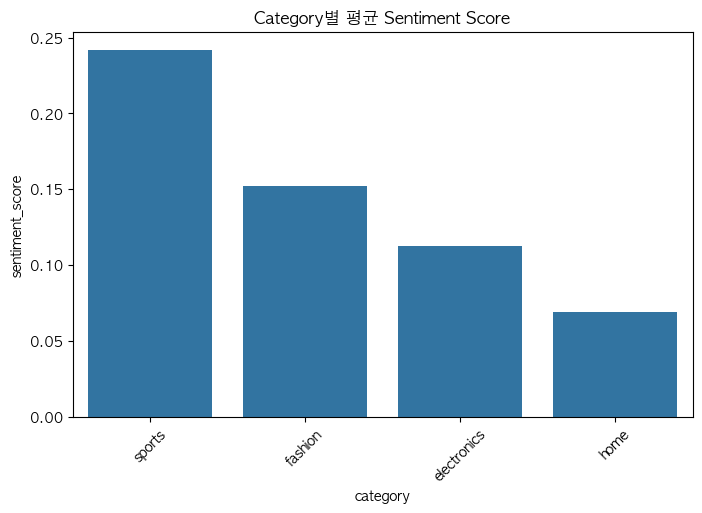

In [9]:
# 7. Category별 평균 Sentiment Score
category_sentiment = df_clean.groupby('category')['sentiment_score'].mean().sort_values(ascending=False)
print("Category별 평균 Sentiment Score:")
print(category_sentiment)

plt.figure(figsize=(8, 5))
sns.barplot(data=df_clean, x='category', y='sentiment_score', ci=None, order=category_sentiment.index)
plt.title('Category별 평균 Sentiment Score')
plt.xticks(rotation=45)
plt.show()

리뷰 길이와 평균 Embedding Similarity 상관계수: 0.044


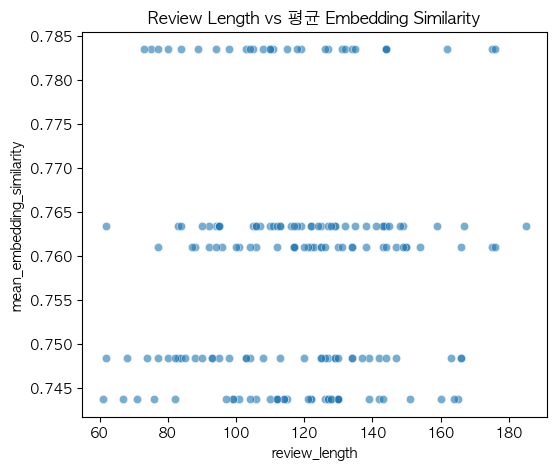

In [ ]:
# 9. Review Length vs 평균 Embedding Similarity 
# 1) 임베딩 생성
model = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')
texts = df_clean['review_text'].fillna("").tolist()
embeddings = model.encode(texts, convert_to_tensor=True)

# 2) 모든 리뷰 쌍 간 코사인 유사도 행렬 계산
similarity_matrix = util.cos_sim(embeddings, embeddings).cpu().numpy()

# 3) 자기 자신과의 유사도(=1.0) 제외한 평균 유사도 계산
mean_similarities = []
for i in range(len(similarity_matrix)):
    # i번째 리뷰의 다른 리뷰들과의 평균 유사도
    sims = np.delete(similarity_matrix[i], i)  # 자기 자신 제외
    mean_similarities.append(np.mean(sims))

# 4) 데이터프레임에 평균 유사도 컬럼 추가
df_clean['mean_embedding_similarity'] = mean_similarities

# 5) 상관계수 확인
corr_length_mean_similarity = df_clean['review_length'].corr(df_clean['mean_embedding_similarity'])
print(f"리뷰 길이와 평균 Embedding Similarity 상관계수: {corr_length_mean_similarity:.3f}")

# 6) 시각화
plt.figure(figsize=(6, 5))
sns.scatterplot(data=df_clean, x='review_length', y='mean_embedding_similarity', alpha=0.6)
plt.title('Review Length vs 평균 Embedding Similarity')
plt.show()
